# Import

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import matplotlib

plt.rcParams["figure.figsize"] = (20, 6.5)

# Function

In [80]:
## process_file() takes a string with a path to the .csv
def process_file(pathname):
    res = pd.read_csv(pathname, sep = ',', header = 0, index_col = None, names = ['time', 'seconds', 'z', 'y', 'x'])
    # res = res[(res['seconds'] >= 10) & (res['seconds'] <=70)]
    return res
def read_fft_file(pathname):
    res = pd.read_csv(pathname, sep=',', header=0, index_col=None, names=['x','y'])
    return res


In [81]:
# Processing .csv files, passing them through Butterworth filter, and Fourier transforming them

# Matt right pocket screen on/off
# trim raw file
matt_rp50_screen_off = process_file('data/matt_rp50_1min_screenoff.csv')
matt_rp50_screen_on = process_file('data/matt_rp50_1min_screenon.csv')

# butterworth filter (bw)
matt_rp50_screen_off_bw = process_file(
    'processed_data/mrp_1min_screenoff_bw.csv')
matt_rp50_screen_on_bw = process_file(
    'processed_data/mrp_1min_screenon_bw.csv')

# fourier transform(fft)
#   raw_fft
matt_rp50_screen_off_fft = read_fft_file(
    'processed_data/mrp_1min_screenoff_fft.csv')
matt_rp50_screen_on_fft = read_fft_file(
    'processed_data/mrp_1min_screenon_fft.csv')

#   bw_fft
matt_rp50_screen_off_bw_fft = read_fft_file(
    'processed_data/mrp50_1min_screenoff_bw_fft.csv')
matt_rp50_screen_on_bw_fft = read_fft_file(
    'processed_data/mrp50_1min_screenon_bw_fft.csv')


# Raw Plot

Text(0.05, 0.048, "Figure: Matt's device screen (Top: keep off / Bottom: keep on)")

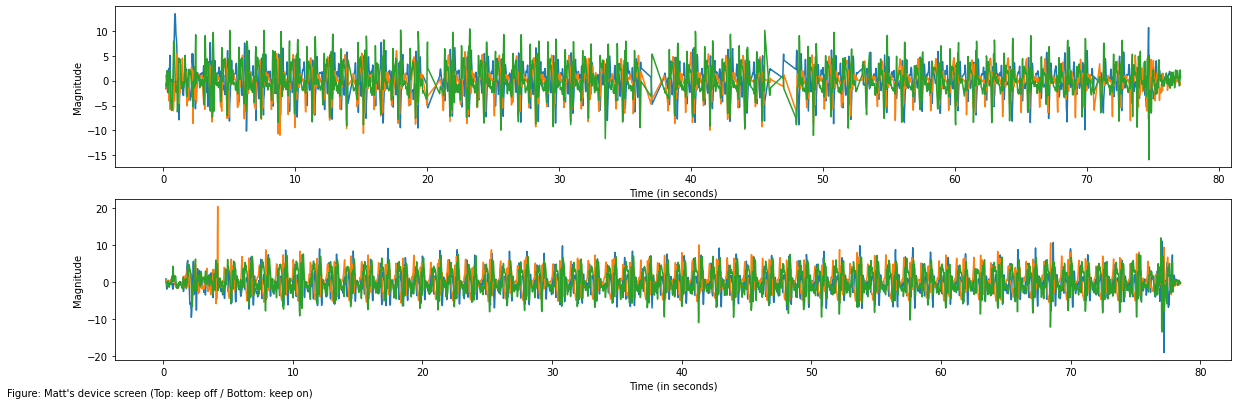

In [82]:
# Plotting Butterworth filtered data. Each line represents an axis.
fig, ax = plt.subplots(2)
ax[0].set(xlabel='Time (in seconds)')
ax[0].set(ylabel='Magnitude')

# screen off plot
ax[0].plot(matt_rp50_screen_off['seconds'], matt_rp50_screen_off['x'])
ax[0].plot(matt_rp50_screen_off['seconds'], matt_rp50_screen_off['y'])
ax[0].plot(matt_rp50_screen_off['seconds'], matt_rp50_screen_off['z'])

ax[1].set(xlabel='Time (in seconds)')
ax[1].set(ylabel='Magnitude')

# Matt
# screen on plot
ax[1].plot(matt_rp50_screen_on['seconds'], matt_rp50_screen_on['x'])
ax[1].plot(matt_rp50_screen_on['seconds'], matt_rp50_screen_on['y'])
ax[1].plot(matt_rp50_screen_on['seconds'], matt_rp50_screen_on['z'])

plt.figtext(
    0.05, 0.048, 'Figure: Matt\'s device screen (Top: keep off / Bottom: keep on)')





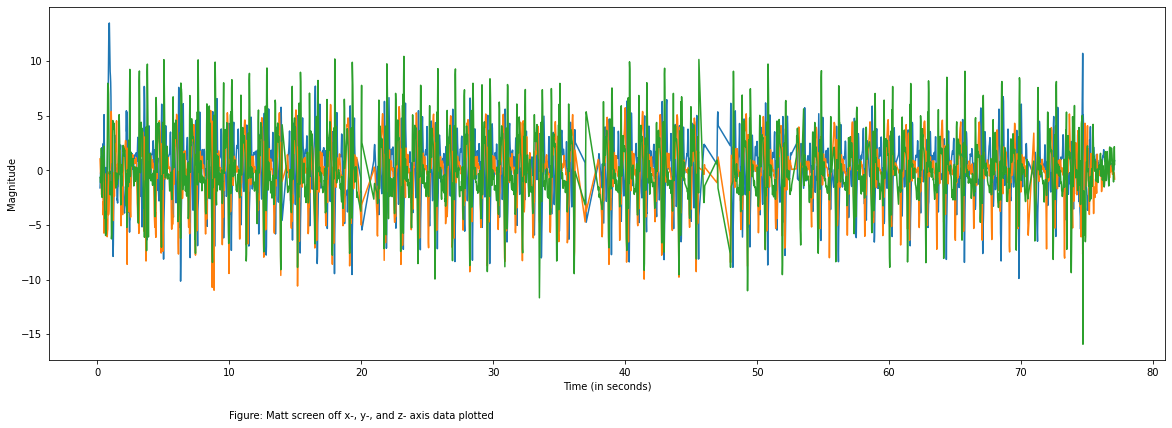

In [83]:
plt.xlabel('Time (in seconds)')
plt.ylabel('Magnitude')
# plt.text(10, -20, 'Figure: Matt screen off x-, y-, and z- axis data plotted')
plt.figtext(0.25, -0, 'Figure: Matt screen off x-, y-, and z- axis data plotted')

plt.plot(matt_rp50_screen_off['seconds'], matt_rp50_screen_off['x'])
plt.plot(matt_rp50_screen_off['seconds'], matt_rp50_screen_off['y'])
plt.plot(matt_rp50_screen_off['seconds'], matt_rp50_screen_off['z'])


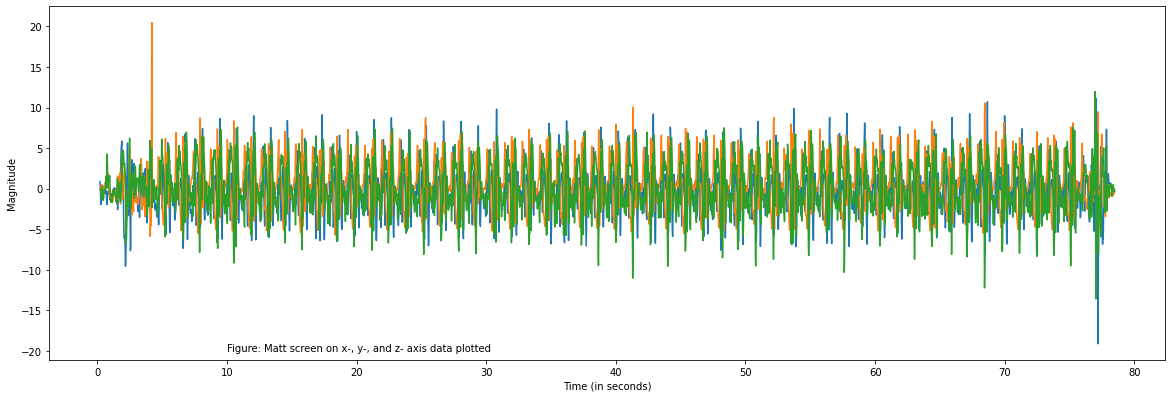

In [84]:
plt.xlabel('Time (in seconds)')
plt.ylabel('Magnitude')
# plt.figure(.)
plt.text(10, -20, 'Figure: Matt screen on x-, y-, and z- axis data plotted')

plt.plot(matt_rp50_screen_on['seconds'], matt_rp50_screen_on['x'])
plt.plot(matt_rp50_screen_on['seconds'], matt_rp50_screen_on['y'])
plt.plot(matt_rp50_screen_on['seconds'], matt_rp50_screen_on['z'])


# Butterworth Filter

Compare the screeen on/off plot, we can see that when we record the screen off data, the device may ask the app to sleep down in a regular pattern.
So the data is going to be inaccurate with screen off.

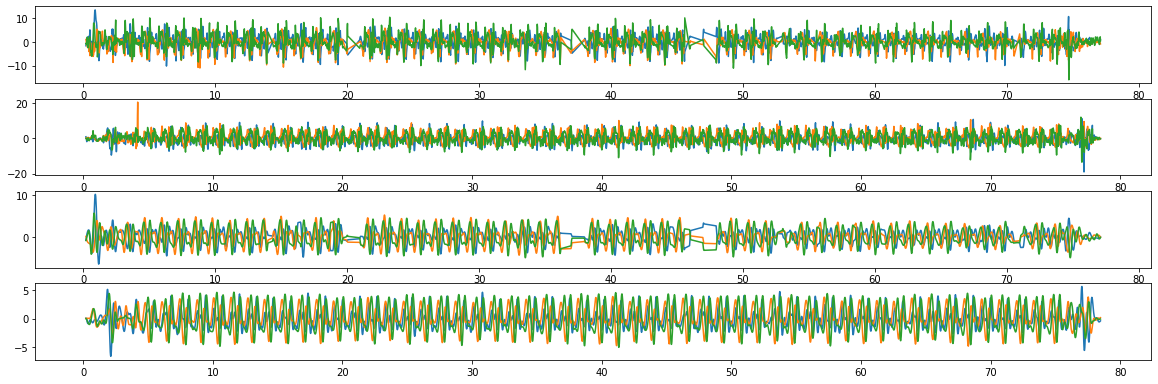

In [85]:
fig, ax = plt.subplots(4)

# screen off raw data plot
ax[0].plot(matt_rp50_screen_off['seconds'], matt_rp50_screen_off['x'])
ax[0].plot(matt_rp50_screen_off['seconds'], matt_rp50_screen_off['y'])
ax[0].plot(matt_rp50_screen_off['seconds'], matt_rp50_screen_off['z'])

# screen on raw data plot
ax[1].plot(matt_rp50_screen_on['seconds'], matt_rp50_screen_on['x'])
ax[1].plot(matt_rp50_screen_on['seconds'], matt_rp50_screen_on['y'])
ax[1].plot(matt_rp50_screen_on['seconds'], matt_rp50_screen_on['z'])

# bw screen off bw filtered data plot
ax[2].plot(matt_rp50_screen_off_bw['seconds'], matt_rp50_screen_off_bw['x'])
ax[2].plot(matt_rp50_screen_off_bw['seconds'], matt_rp50_screen_off_bw['y'])
ax[2].plot(matt_rp50_screen_off_bw['seconds'], matt_rp50_screen_off_bw['z'])

# bw screen on bw filtered data plot
ax[3].plot(matt_rp50_screen_on_bw['seconds'], matt_rp50_screen_on_bw['x'])
ax[3].plot(matt_rp50_screen_on_bw['seconds'], matt_rp50_screen_on_bw['y'])
ax[3].plot(matt_rp50_screen_on_bw['seconds'], matt_rp50_screen_on_bw['z'])






# Fourier Transform

Whether data has been filterd or not, it doesn't  really affect the result of the Fourier Transform

(0.0, 1.0)

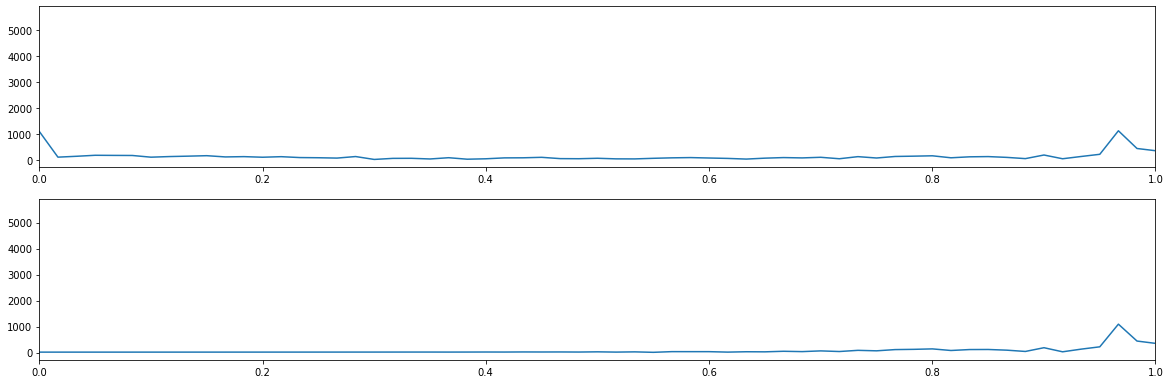

In [86]:
# Plotting Fourier transformed data. Each line represents a collection point (left pocket vs. right pocket).
fig, ax = plt.subplots(2)

# raw_fft on/off
#ax[0].plot(matt_rp50_screen_off_fft['x'], matt_rp50_screen_off_fft['y'])
ax[0].plot(matt_rp50_screen_on_fft['x'], matt_rp50_screen_on_fft['y'])
ax[0].set_xlim(0, 1)

# bw_fft on_off
#ax[1].plot(matt_rp50_screen_off_bw_fft['x'], matt_rp50_screen_off_bw_fft['y'])
ax[1].plot(matt_rp50_screen_on_bw_fft['x'], matt_rp50_screen_on_bw_fft['y'])
ax[1].set_xlim(0, 1)
